**Part A: Preprocessing and Initial Setup**

Since the dataset contains 14 labels, visualizing all of them directly would be overwhelming. To simplify this, we reduce the labels into four categories:
- the two most frequent single-label classes
- the most frequent multi-label combination
- “Other” category for the remaining samples

So first we want to identify single-label instances by selecting rows where exactly one label is active. Then we count how many times each class occurs alone and picks the top two as representative single-label classes. Multi-label instances are similarly examined to find the most common combination of labels. All remaining samples are assigned to “Other.”

In [4]:
import pandas as pd
import numpy as np
from scipy.io import arff
from collections import Counter


data, meta = arff.loadarff("yeast.arff")
df = pd.DataFrame(data)

print("DataFrame shape:", df.shape)

# Split into features (first 103) and labels (last 14)
X = df.iloc[:, :103].values
Y = df.iloc[:, 103:].astype(int).values

print("Feature matrix X shape:", X.shape)
print("Label matrix Y shape:", Y.shape)

# Extract proper label names (last 14 columns)
n_labels = Y.shape[1]
label_names = list(df.columns[103:103+n_labels])

#identify single label rows
single_label_mask = (Y.sum(axis=1) == 1)
single_label_indices = np.where(single_label_mask)[0]

# count distribution across labels
single_label_counts = Y[single_label_indices].sum(axis=0)
single_label_distribution = pd.Series(single_label_counts, index=label_names)

print("\nSingle-label distribution (all classes):")
print(single_label_distribution.sort_values(ascending=False))

#get top 2 most frequent single-label class names
top_two_single_labels = single_label_distribution.sort_values(ascending=False).index[:2]

print("\nTop two single-label classes:")
print("1.", top_two_single_labels[0])
print("2.", top_two_single_labels[1])

#find most frequent multi-label combination
multi_label_mask = (Y.sum(axis=1) > 1)
multi_label_combos = []
for row in Y[multi_label_mask]:
    combo = tuple(np.array(label_names)[np.where(row == 1)[0]])
    multi_label_combos.append(combo)

combo_counter = Counter(multi_label_combos)
top_multi_combo = combo_counter.most_common(1)[0][0]

print("\nMost frequent multi-label combo:", top_multi_combo)

# Create new color_label column
color_label = []
for row in Y:
    active = np.where(row == 1)[0]
    active_labels = list(np.array(label_names)[active])

    if len(active_labels) == 1:  # single-label case
        if active_labels[0] == top_two_single_labels[0]:
            color_label.append(f"Single-{top_two_single_labels[0]}")
        elif active_labels[0] == top_two_single_labels[1]:
            color_label.append(f"Single-{top_two_single_labels[1]}")
        else:
            color_label.append("Other")
    else:  # multi-label case
        if tuple(active_labels) == top_multi_combo:
            color_label.append(f"Multi-{top_multi_combo}")
        else:
            color_label.append("Other")

df["color_label"] = color_label


print("\nCategories created for visualization:")
print(f"- Single-{top_two_single_labels[0]}")
print(f"- Single-{top_two_single_labels[1]}")
print(f"- Multi-{top_multi_combo}")
print("- Other")

print("\nNew target variable distribution:")
print(df["color_label"].value_counts())


DataFrame shape: (2417, 117)
Feature matrix X shape: (2417, 103)
Label matrix Y shape: (2417, 14)

Single-label distribution (all classes):
Class1     32
Class2      0
Class3      0
Class4      0
Class5      0
Class6      0
Class7      0
Class8      0
Class9      0
Class10     0
Class11     0
Class12     0
Class13     0
Class14     0
dtype: int64

Top two single-label classes:
1. Class1
2. Class2

Most frequent multi-label combo: (np.str_('Class3'), np.str_('Class4'), np.str_('Class12'), np.str_('Class13'))

Categories created for visualization:
- Single-Class1
- Single-Class2
- Multi-(np.str_('Class3'), np.str_('Class4'), np.str_('Class12'), np.str_('Class13'))
- Other

New target variable distribution:
color_label
Other                                                                                   2148
Multi-(np.str_('Class3'), np.str_('Class4'), np.str_('Class12'), np.str_('Class13'))     237
Single-Class1                                                                           

After loading the Yeast dataset (yeast.arff), we obtained a total of 2417 samples with 117 columns. These columns consist of 103 gene expression features (Att1–Att103) and 14 functional category labels (Class1–Class14). The feature matrix X  has the shape (2417, 103) and the multi-label target matrix Y has the shape (2417, 14).

From the analysis, we observe that most samples in the yeast dataset belong to either complex multi-label combinations or less frequent single-label classes.

- Only a small number of samples (32) are associated with a single label (Class1), while another single-label classes has no pure instances.
- The most common multi-label combination involves Class3, Class4, Class12, and Class13, accounting for 237 samples.
- The vast majority of samples (2148) fall into other, less frequent patterns.


In [5]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the feature matrix
X_scaled = scaler.fit_transform(X)

print("Shape of scaled feature matrix:", X_scaled.shape)
print("Mean of first feature after scaling:", X_scaled[:, 0].mean())
print("Std of first feature after scaling:", X_scaled[:, 0].std())


Shape of scaled feature matrix: (2417, 103)
Mean of first feature after scaling: 1.9843456625488937e-17
Std of first feature after scaling: 1.0


t-SNE a distance-based dimensionality reduction technique relies on measures like Euclidean distance to determine the structure of the data. If features are on different scales (e.g., one feature ranges from 0–1 while another ranges 0–1000) the larger-scaled features will dominate the distance calculations. Standardization (mean = 0, variance = 1) ensures that all features contribute equally, allowing the dimensionality reduction to capture meaningful patterns.

**Part B: t-SNE and Veracity Inspection**

Perplexity in t-SNE controls how much the algorithm focuses on local versus global data structure. Lower perplexity values make t-SNE emphasize small, tight clusters and local patterns. Higher perplexity values help show broader, global groupings in the data. Typical values of perplexity range from 5 to 50. So we try a few values in this range and choose the one that produces the clearest separation.

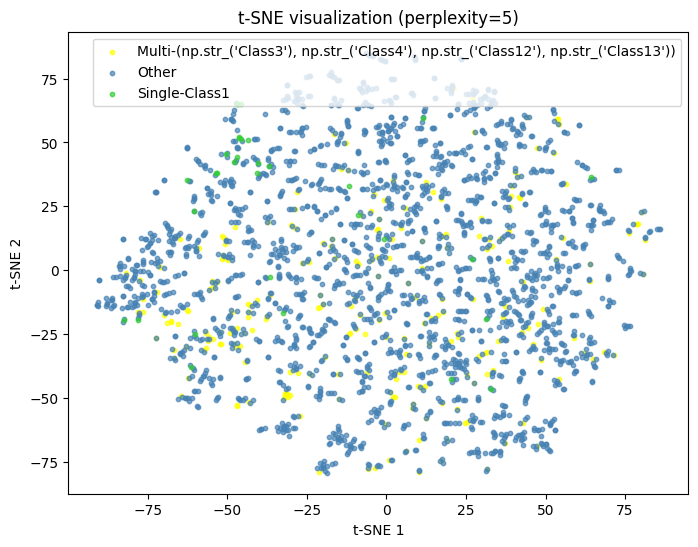

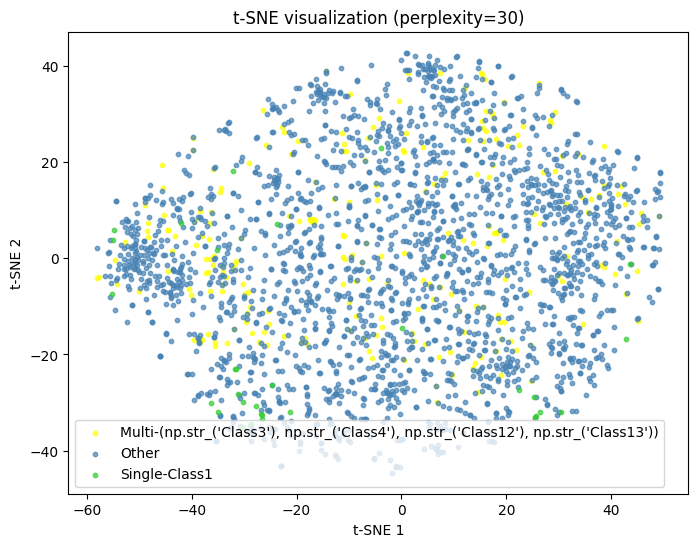

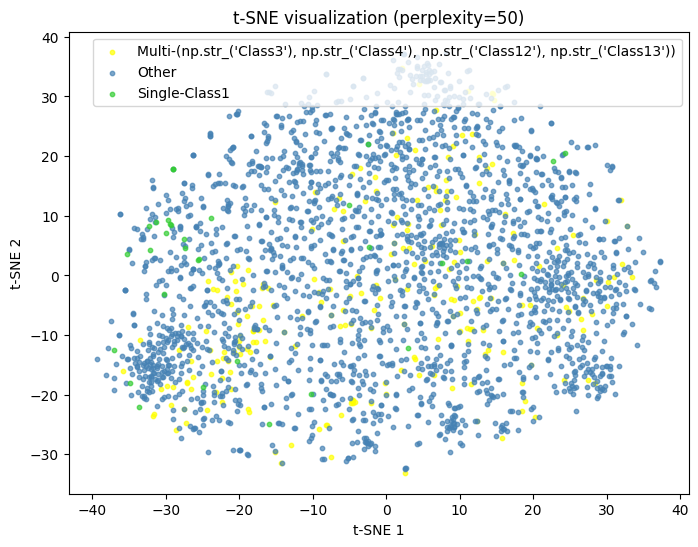

In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Set up list of perplexities to try
perplexities = [5, 30, 50]

# Use the color_label column created earlier for coloring
labels = df["color_label"].values
unique_labels = np.unique(labels)
colors = ['Yellow', 'SteelBlue', 'LimeGreen', 'DeepPink']  # one color per category

for perp in perplexities:
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)

    plt.figure(figsize=(8,6))
    for i, ul in enumerate(unique_labels):
        idx = labels == ul
        plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], c=colors[i], label=ul, alpha=0.7, s = 10)

    plt.title(f"t-SNE visualization (perplexity={perp})")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend()
    plt.show()


We can see that lower perplexity values (such as 5) bring out local relationships which helps to identify tight clusters but sometimes this means missing broader patterns in the data.
Moderate values (such as 30) often provide a balance, revealing both local clusters and larger-scale groupings.
Higher perplexity values (such as 50) help to highlight global structures.

For further analysis I use perplexity = 30 which is intermediate between the 2 scales.

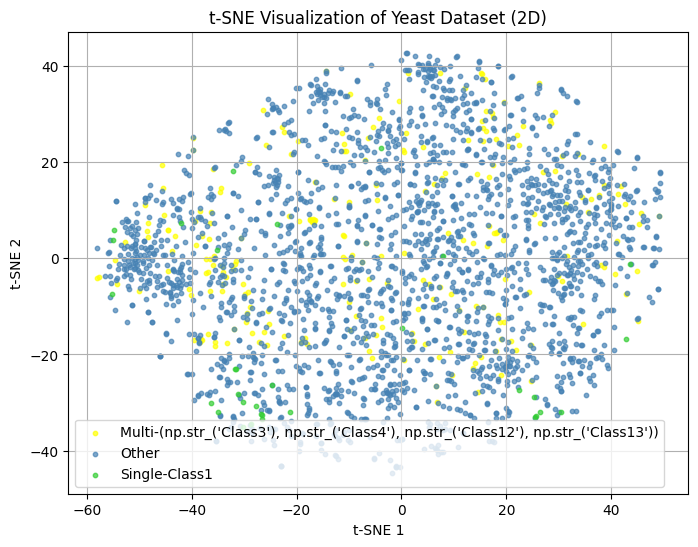

In [9]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Final t-SNE with chosen perplexity (30)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Get labels for coloring
labels = df["color_label"].values
unique_labels = np.unique(labels)

# Define colors for the a4 categories
colors = ['Yellow', 'SteelBlue', 'LimeGreen', 'DeepPink']

# Plot
plt.figure(figsize=(8,6))
for i, ul in enumerate(unique_labels):
    idx = labels == ul
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], c=colors[i], label=ul, alpha=0.7, s=10)

plt.title("t-SNE Visualization of Yeast Dataset (2D)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(True)
plt.show()


**Noisy/Ambiguous Labels**
- Noisy or ambiguous labels are visible where yellow or green points are  within large blue clusters.
- These sites indicate that some data points labeled as one category share local feature similarities with another class maybe due to overlapping expression profiles, labeling errors, or ambiguity in the dataset.

**Outliers**
- Outliers are isolated points or tiny clusters that sit far away from the main data cloud.
- These could be a single yellow or green dot well separated from any cluster, or a small group detached from the dense blue region.
These patterns may represent rare cellular states that does not conform to the typical sample structure.

**Hard-to-Learn Samples**
- Hard-to-learn samples are found where color mixing is dense like the areas where yellow, green, and blue points are distributed all together without clear separation.
- In these mixed regions, class boundaries are highly non-linear and making it difficult for simple classifiers to distinguish between categories.
- Classification here might require complex decision boundaries which maybe limited by the available features.

**Part C: Isomap and Manifold Learning**

Isomap preserves global geometric structure by estimating geodesic distances (distance along the surface) along the manifold. It maintains approximate true distances between all points along the intrinsic manifold. It is better for capturing the overall shape of the data but may be less sensitive to very fine local clustering.

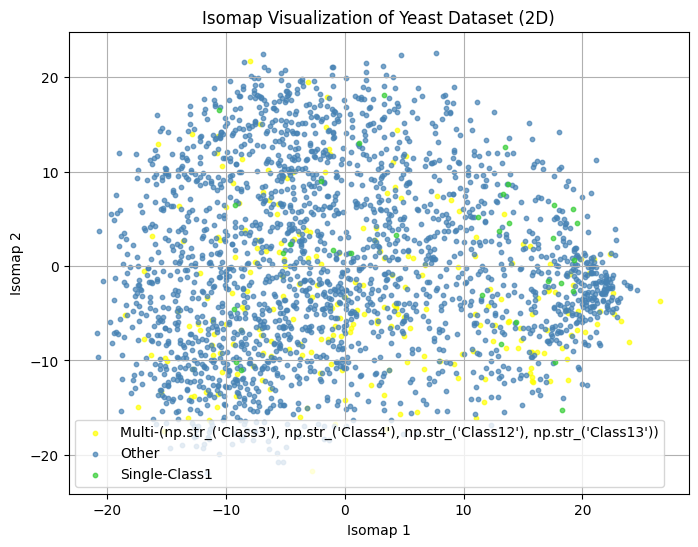

In [10]:
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
import numpy as np

# Initialize Isomap (n_neighbors can be tuned, e.g., 5, 10, 20)
isomap = Isomap(n_components=2, n_neighbors=10)
X_isomap = isomap.fit_transform(X_scaled)

# Labels for coloring
labels = df["color_label"].values
unique_labels = np.unique(labels)
colors = ['Yellow', 'SteelBlue', 'LimeGreen', 'DeepPink']  # match 4 categories

# Plot Isomap 2D projection
plt.figure(figsize=(8,6))
for i, ul in enumerate(unique_labels):
    idx = labels == ul
    plt.scatter(X_isomap[idx, 0], X_isomap[idx, 1], c=colors[i], label=ul, alpha=0.7, s=10)

plt.title("Isomap Visualization of Yeast Dataset (2D)")
plt.xlabel("Isomap 1")
plt.ylabel("Isomap 2")
plt.legend()
plt.grid(True)
plt.show()


Looking at the plots for Isomap and T SNE, the isomap visualization shows a more continuous pattern which is spread out, where the points are arranged to reflect global scale similarities. This means Isomap does a better job at showing that in the gene expression data how samples relate overall. In contrast, the t-SNE plot clusters points tightly which emphasizes the local neighborhoods but blurs the broader relationships across the data.


Regarding the data manifold, we can make the following observations.
- The points are spread across a roughly rectangular 2D space, but there are some regions that seem denser or slightly curved.
- There doesn’t appear to be a simple straight-line structure, but the overall spread is not forming a very sharply twisted or having any extreme bends or twists.
- This suggests that the data lies on a moderately curved or slightly nonlinear manifold.

Isomap is good at preserving global geometry, so if the manifold were highly curved or rolled up like a Swiss roll we would see the 2D embedding unrolled into a more spread out plane.Also since the classes are not tangled in a highly complex shape, overlapping points in gene expression make separation hard.

In short it is a moderately curved manifold which is not purely linear, but also not extremely twisted.

# **Conclusion**

From a classification perspective, while classes are not highly entangled there are overlapping points and subtle variations in gene expression which make simple linear separation difficult. The predominance of the “Other” category and sparsity of pure single-label category also make the separation difficult.

These characteristics imply that the dataset suffers from verasity challenges that models must account for both local distinctions and global relationships to achieve accurate predictions.


*Why t-SNE and Isomap Are Not Ideal for This Dataset:*

While both t-SNE and Isomap help reveal hidden structures in high-dimensional data, they are not  well-suited this yeast dataset due to the following reasons:

t-SNE limitations:
- It preserves local neighborhoods but distorts global distances.
- Clusters in 2D may appear far apart even if they are close in the original space.
- The output is also sensitive to hyperparameters like perplexity.

Isomap limitations:
- It emphasizes global structure but may smooth over local differences which is important for separating classes.
- It assumes the data lies on a relatively smooth manifold, but gene expression data often has noise, label imbalance and overlaps, which violate these assumptions.

Dataset-specific challenges:
The yeast dataset has label sparsity and imbalance (it has only 1 single-label instance, a dominant "Other" group).

Both t-SNE and Isomap can show clusters, but as shown by the plots - they don’t resolve the overlaps and variations in gene expression that cause difficulty in classification.